In [102]:
#install library kaggle untuk download dataset
!pip install kaggle


In [103]:
#buat directory .kaggle
!mkdir .kaggle
!ls -a


mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	.kaggle  model.png  sample_data


In [104]:
#buat token untuk bisa akses download dataset
import json, os
token = {"username":"donodanar35","key":"92c113ad1a2fdabc92ea0f3fe5666e90"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

os.listdir('.kaggle/')
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [105]:
#download dataset IMDB - dataset yang berisi review film dengan 50K data dan 2 sentimen (positif dan negatif)
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format -p /tmp

imdb-dataset-sentiment-analysis-in-csv-format.zip: Skipping, found more recently modified local copy (use --force to force download)


In [106]:
import zipfile,os
local_zip = '/tmp/imdb-dataset-sentiment-analysis-in-csv-format.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

#ekstra dataset file zip ke destinasi /tmp
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp')

['tmp3ri0a1xr.py',
 'Train.csv',
 'imdb-dataset-sentiment-analysis-in-csv-format.zip',
 'Test.csv',
 'tmpajl4yywv.py',
 'Valid.csv',
 '__pycache__']

In [107]:
#baca dataset IMB menggunakan dataframe pandas
import pandas as pd

df = pd.read_csv('/tmp/Train.csv', names=['text', 'label'], sep=',')
df = df.drop(0)
df

,text,label
1,I grew up (b. 1965) watching and loving the Th...,0
2,"When I put this movie in my DVD player, and sa...",0
3,Why do people who do not know what a particula...,0
4,Even though I have great interest in Biblical ...,0
5,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39996,"""Western Union"" is something of a forgotten cl...",1
39997,This movie is an incredible piece of work. It ...,1
39998,My wife and I watched this movie because we pl...,0
39999,"When I first watched Flatliners, I was amazed....",1


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 1 to 40000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


In [109]:
from sklearn.model_selection import train_test_split

#pisahkan dataset training dan dataset validation sebenar 80% dan 20%
review = df['text'].values
y = df['label'].values
review_latih, review_val, y_latih, y_val = train_test_split(review, y, test_size=0.2)


In [110]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
     
#lakukan tokenisasi
tokenizer = Tokenizer(num_words=500, oov_token='-')
tokenizer.fit_on_texts(review_latih) 
tokenizer.fit_on_texts(review_val)

#lakukan sequence     
sekuens_latih = tokenizer.texts_to_sequences(review_latih)
sekuens_val = tokenizer.texts_to_sequences(review_val)
     
padded_latih = pad_sequences(sekuens_latih, padding='post', maxlen=300,truncating='post') 
padded_val = pad_sequences(sekuens_val, padding='post', maxlen=300,truncating='post')

#convert dataset label (y) menjadi float biar bisa dibaca tensorflow
y_latih = np.asarray(y_latih).astype('float').reshape((-1,1))
y_val = np.asarray(y_val).astype('float').reshape((-1,1))

In [111]:
y_latih[100]

array([0.])

In [112]:
padded_latih[100]

array([  4,   1,   1,   7,   1,  18, 397,   1,   9,  33,   1,   6,   1,
         2, 396, 397, 110,  25, 160,  46,  93,  10,   6,   2, 223, 117,
        29,  68, 188,   4, 397,   1,   3,   1,  95,   1,   6,  13,   5,
        33,   1,   1,   4, 172, 484,  25,   1,   1,   7,   4,   1,   1,
        19, 488, 286,  37,   2,   1,   1,   1,   1,   6,   2, 271,   1,
         1,   8,   8,   1,   1,  32,   1,   2,  20,  22,  24,  42,   6,
        64,   7,  23,  30,   1,   1,  10,   7, 443,   1,   1,   1,  61,
         1,   1,  16,   1,   1,   1,   2,   1,  10,  99,  27,   4,   1,
         1,  39,   1,   1,   6,   1,   1,   1,   1,   1, 203,   3,   1,
         1,   1,   1, 309,  31,   4,   1,  18,   1,   1,   8,   8,  88,
        74,  64,   1,   1,  15,   1,   1,   1,   1,   4,   1,   3,   1,
         1, 104,  13,   1, 296,   4,   1, 479,  29,   1,   4,   1, 436,
         1, 308,   2,   1,   1, 347,  29,   1,  10,   7,   1,   3,   1,
         6,   1,   2, 115,   5,  28,   5,   2,   1,   1,   6,  2

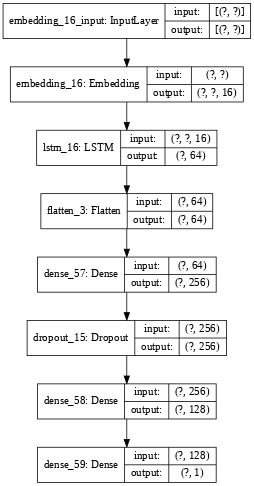

In [113]:
import tensorflow as tf

#bangun model
n = len(tokenizer.word_index)
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=n, output_dim=16),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') #gunakan activation sigmoid untuk 2 kelas data 
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

#buat visualisasi model
model_visual = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_visual

In [114]:
#buat ringkasan model
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 16)          1795264   
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                20736     
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

In [115]:
#buat kelas dan fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      if(logs.get('accuracy')>0.85):      
        print("\nAkurasi data latih dan validation telah mencapai >85%!")
        self.model.stop_training = True
callbacks = myCallback()

#lakukan pelatihan model
history = model.fit(padded_latih, y_latih, epochs=80, 
                    validation_data=(padded_val, y_val), validation_steps=20, verbose=2, callbacks=[callbacks])


Epoch 1/80
1000/1000 - 25s - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6911 - val_accuracy: 0.5079
Epoch 2/80
1000/1000 - 25s - loss: 0.6797 - accuracy: 0.5498 - val_loss: 0.6256 - val_accuracy: 0.6640
Epoch 3/80
1000/1000 - 25s - loss: 0.6718 - accuracy: 0.5723 - val_loss: 0.5878 - val_accuracy: 0.7239
Epoch 4/80
1000/1000 - 25s - loss: 0.6722 - accuracy: 0.5554 - val_loss: 0.6879 - val_accuracy: 0.5381
Epoch 5/80
1000/1000 - 25s - loss: 0.6804 - accuracy: 0.5410 - val_loss: 0.6309 - val_accuracy: 0.6258
Epoch 6/80
1000/1000 - 25s - loss: 0.6787 - accuracy: 0.5412 - val_loss: 0.7316 - val_accuracy: 0.4950
Epoch 7/80
1000/1000 - 24s - loss: 0.6854 - accuracy: 0.5206 - val_loss: 0.6867 - val_accuracy: 0.5194
Epoch 8/80
1000/1000 - 25s - loss: 0.6829 - accuracy: 0.5215 - val_loss: 0.6885 - val_accuracy: 0.5297
Epoch 9/80
1000/1000 - 24s - loss: 0.6832 - accuracy: 0.5388 - val_loss: 0.6841 - val_accuracy: 0.5455
Epoch 10/80
1000/1000 - 24s - loss: 0.6745 - accuracy: 0.5489 - val_loss:

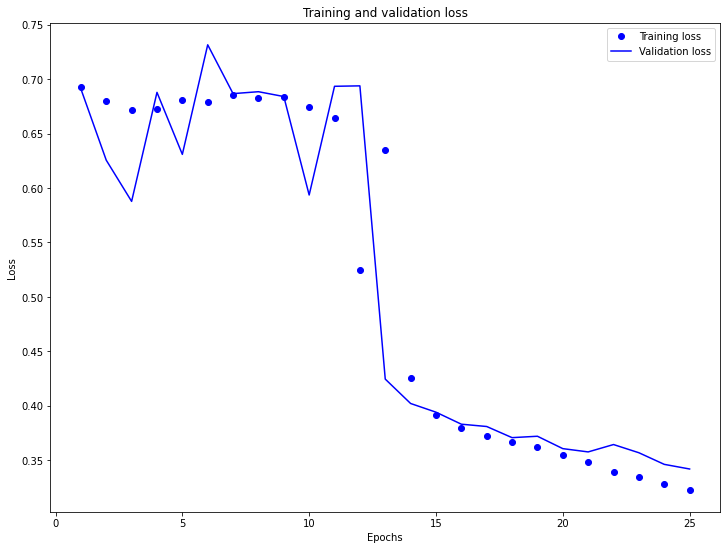

In [123]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

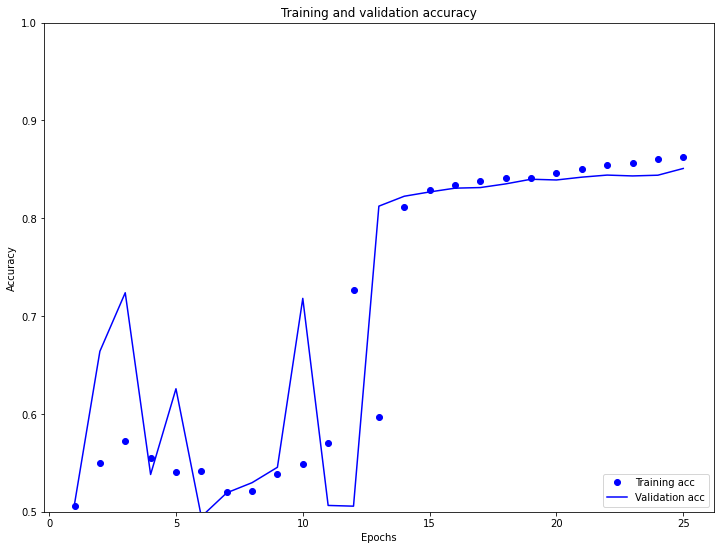

In [122]:
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()